In [1]:
# import DMeRates
import DMeRates.DMeRate as DMeRate
import torch
import numericalunits as nu
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True  # Enable LaTeX
params = {'text.usetex' : True,
            'font.size' : 12,
            'font.family' : 'cmr10',
            'figure.autolayout': True
            }
plt.rcParams.update(params)
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=10

In [2]:
FDMn = 2

halo_model = 'shm'
DoScreen = False
test_mX = 10. #MeV
test_mX_eV = test_mX*1e6
test_mX_unitized= test_mX * nu.MeV / nu.c0**2
ne = 1
cs = 1e-36
cs_unitized = cs * nu.cm**2
nes = [1,2,3,4,5,6,7,8,9,10]
mX_array = np.concatenate((np.arange(0.2,0.8,0.025),np.array([0.9]),np.arange(1,5,0.05),np.arange(5,11,1),np.array([20,50,100,200,500,1000,10000]))) #MeV


In [3]:
from QCDark.dark_matter_rates import d_rate,default_screening,default_si,read_output,default_astro
default_astro['sigma_e'] = cs

from QCDark.dark_matter_rates import form_factor as qcdark_form_factor



if DoScreen:
    screening = default_si
else:
    screening = default_screening
cff = read_output('QCDark/results/Si_final.hdf5')
Ee_old, dR_old= d_rate(test_mX_eV, cff, FDM_exp = FDMn, screening = screening, astro_model = default_astro)

from QEDark.QEDark2 import QEDark
qedark = QEDark()

Ee_qe = np.arange(0,50,0.1)
drde_qedark = qedark.vectorized_dRdE('Si',test_mX_eV,Ee_qe,FDMn,'imb',DoScreen=DoScreen)


import DMeRates
import DMeRates.DMeRate
dmrates = DMeRate.DMeRate('Si',QEDark=False)
dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)



dmrates.update_crosssection(cs)

# drde_qcdark_redo_res = dmrates.vectorized_dRdE(test_mX,FDMn,halo_model,DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
drde_qedark_redo = dmrates_qedark.vectorized_dRdE(test_mX,FDMn,'imb',DoScreen=DoScreen,integrate=False,unitize=True,debug=False).cpu().numpy()
drde_qcdark_redo_res = dmrates.vectorized_dRdE(test_mX,FDMn,'shm',DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
drde_qcdark_redo_mod_res = dmrates.vectorized_dRdE(test_mX,FDMn,'modulated',DoScreen=DoScreen,integrate=True,unitize=True,debug=True,isoangle=35,useVerne=True) 
drde_qcdark_redo_mod = drde_qcdark_redo_mod_res['drde'].cpu().numpy()
drde_qcdark_redo = drde_qcdark_redo_res['drde'].cpu().numpy()
Earr = dmrates.Earr.cpu().numpy()
Earr /= nu.eV

Earr_qedark = dmrates_qedark.Earr.cpu().numpy()
Earr_qedark /= nu.eV

CUDA GPU found, performing calculations on GPU
Using form factor calculated from file: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../QCDark/results/Si_final.hdf5
CUDA GPU found, performing calculations on GPU
Using Halo Data from: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../halo_data/modulated/Verne_LM/mDM_10_0_MeV_sigmaE_1e-36_cm2/DM_Eta_theta_35.txt
Using Halo Data from: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../halo_data/modulated/Verne_LM/mDM_10_0_MeV_sigmaE_1e-36_cm2/DM_Eta_theta_35.txt


c:\Users\Ansh\anaconda3\envs\dmerates\Lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
c:\Users\Ansh\anaconda3\envs\dmerates\Lib\site-packages\torchquad\integration\simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(
c:\Users\Ansh\anaconda3\envs\dmerates\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # ty

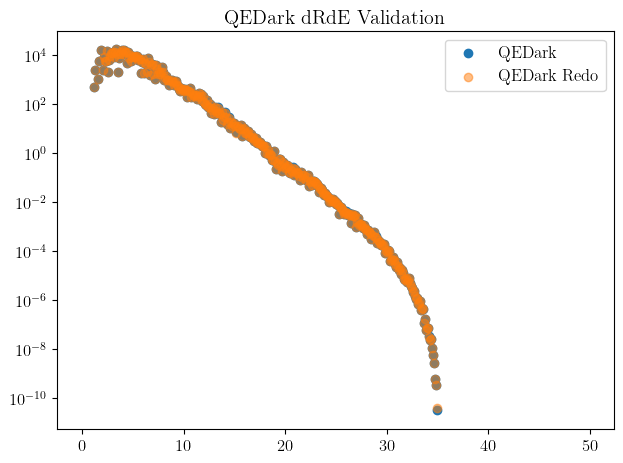

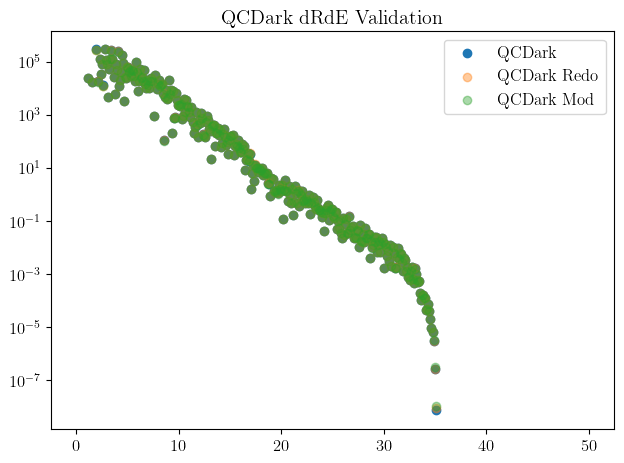

In [4]:


plt.scatter(Earr_qedark,drde_qedark,label='QEDark')
plt.scatter(Earr_qedark,drde_qedark_redo,label='QEDark Redo',alpha=0.5)
plt.yscale('log')
plt.legend()
plt.title('QEDark dRdE Validation')
plt.show()
plt.close()

plt.scatter(Ee_old,dR_old,label='QCDark')
plt.scatter(Earr,drde_qcdark_redo,label='QCDark Redo',alpha=0.4)
plt.scatter(Earr,drde_qcdark_redo_mod,label='QCDark Mod',alpha=0.4)

plt.yscale('log')
plt.legend()
plt.title('QCDark dRdE Validation')
plt.show()
plt.close()




In [5]:
vmin_test = dmrates.vMin_tensor(dmrates.qArr,torch.tensor([dmrates.Earr[19]]),test_mX_unitized)[0]
eta_test_shm = dmrates.get_parametrized_eta(vmin_test,test_mX_unitized,FDMn,'shm')
eta_test_mod = dmrates.get_parametrized_eta(vmin_test,test_mX_unitized,FDMn,'modulated',isoangle=0,useVerne=True)

vmin_test =vmin_test / (nu.km / nu.s)
eta_test_shm = eta_test_shm * nu.year
eta_test_mod = eta_test_mod * nu.year

filter_indices = vmin_test < 800
vmin_test = vmin_test[filter_indices]
eta_test_shm = eta_test_shm[filter_indices]
eta_test_mod = eta_test_mod[filter_indices]

vmin_test = vmin_test.cpu().numpy()
eta_test_shm = eta_test_shm.cpu().numpy()
eta_test_mod = eta_test_mod.cpu().numpy()


sort_idx = np.argsort(vmin_test)
eta_test_shm = eta_test_shm[sort_idx]
eta_test_mod = eta_test_mod[sort_idx]
vmin_test = vmin_test[sort_idx]



Using Halo Data from: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../halo_data/modulated/Verne_LM/mDM_10_0_MeV_sigmaE_1e-36_cm2/DM_Eta_theta_0.txt


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Ansh\AppData\Local\Temp\ipykernel_31112\705498079.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$v_{\mathrm{min}}$')
C:\Users\Ansh\AppData\Local\Temp\ipykernel_31112\705498079.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\eta$')


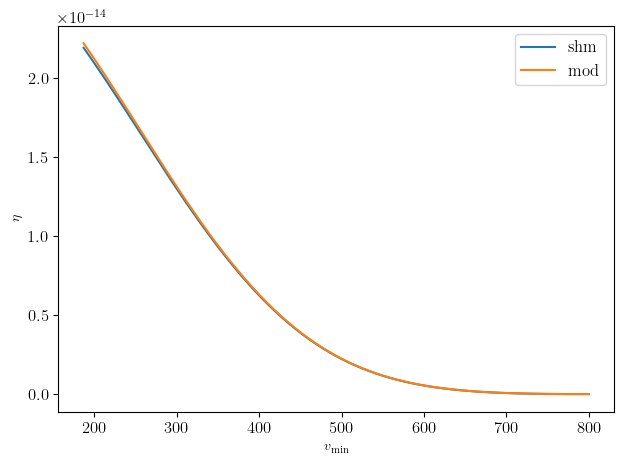

In [6]:
plt.plot(vmin_test,eta_test_shm,label='shm')
plt.plot(vmin_test,eta_test_mod,label='mod')
plt.xlabel('$v_{\mathrm{min}}$')
plt.ylabel('$\eta$')
plt.legend()
plt.show()
plt.close()

In [7]:
print(dmrates.vEscape/ (nu.km / nu.s) )
print(dmrates.vEarth/ (nu.km / nu.s) )

(dmrates.vEscape+ dmrates.vEarth) / (nu.km / nu.s)

544.0
250.20000000000002


794.2

In [8]:
from QCDark.dark_matter_rates import d_rate_FanoQ,d_rate_RamanathanQ

ionizationFile = 'DMeRates/p100k.dat'
ionization_model = 'R'

Si_ff = qcdark_form_factor('QCDark/results/Si_final.hdf5')
from QEDark.QEDark2 import QEDark
qedark = QEDark()
qedark_step= QEDark()
qedark_step.change_to_step()

qcdark_results = []
qedark_results = []
qcdark_results_step = []
qedark_results_step = []

for mX in mX_array: #MeV
    qcdarkeresult = d_rate_RamanathanQ(mX*1e6, Si_ff, ionizationFile, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
    qcdarkeresult = qcdarkeresult[1][ne]
    qcdark_results.append(qcdarkeresult)

    qcdarkeresultstep = d_rate_FanoQ(mX*1e6, Si_ff, 3.8, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
    qcdarkeresultstep = qcdarkeresultstep[1][ne]
    qcdark_results_step.append(qcdarkeresultstep)


    qedarkresult = qedark.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
    qedark_results.append(float(qedarkresult))
    qedarkresultstep = qedark_step.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
    qedark_results_step.append(float(qedarkresultstep))

qedark_results = np.array(qedark_results)
qcdark_results = np.array(qcdark_results)
qedark_results_step = np.array(qedark_results_step)
qcdark_results_step = np.array(qcdark_results_step)



Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.


c:\Users\Ansh\Projects\DarkMatterRates\QEDark\QEDark2.py:769: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ee_array = torch.tensor(Ee_array,device=self.device)


Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be ignored.
Input file has probabilities listed for 1.10 eV <= E <= 50.00 eV.
All rates outside this range will be i

In [22]:
import DMeRates
import DMeRates.DMeRate as DMeRate
dmrates = DMeRate.DMeRate('Si',QEDark=False)
dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)

qcdark_redo = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
qedark_redo = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year


dmrates_qedark.change_to_step()
dmrates.change_to_step()

qcdark_redo_step = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
qedark_redo_step = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year

qedark_redo_step = qedark_redo_step.cpu()
qcdark_redo_step = qcdark_redo_step.cpu()
qedark_redo = qedark_redo.cpu()
qcdark_redo = qcdark_redo.cpu()

CUDA GPU found, performing calculations on GPU
Using form factor calculated from file: c:\Users\Ansh\Projects\DarkMatterRates\DMeRates\../QCDark/results/Si_final.hdf5
CUDA GPU found, performing calculations on GPU


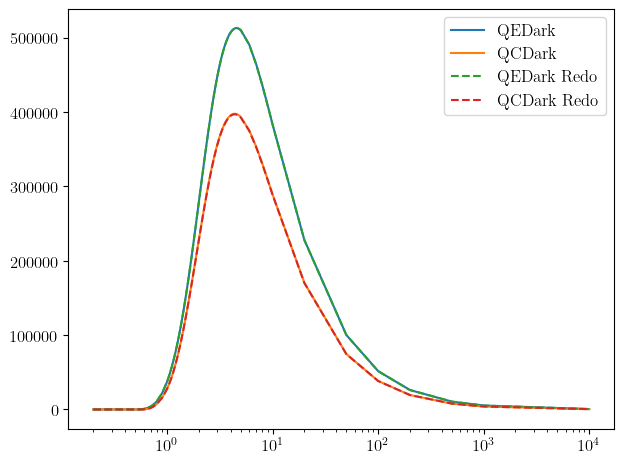

In [23]:
plt.plot(mX_array,qedark_results,label='QEDark')
plt.plot(mX_array,qcdark_results,label='QCDark')
plt.plot(mX_array,qedark_redo,label='QEDark Redo',ls='--')
plt.plot(mX_array,qcdark_redo,label='QCDark Redo',ls='--')

plt.legend()
plt.xscale('log')
# plt.yscale('log')

plt.show()
plt.close()

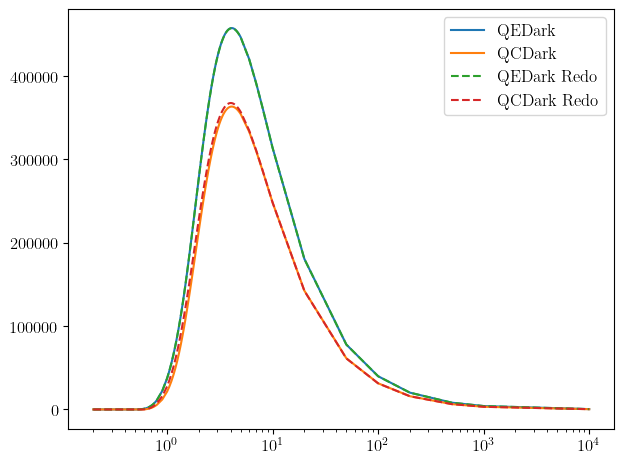

In [24]:
plt.plot(mX_array,qedark_results_step,label='QEDark')
plt.plot(mX_array,qcdark_results_step,label='QCDark')
plt.plot(mX_array,qedark_redo_step,label='QEDark Redo',ls='--')
plt.plot(mX_array,qcdark_redo_step,label='QCDark Redo',ls='--')

plt.legend()
plt.xscale('log')
# plt.yscale('log')

plt.show()
plt.close()

In [1]:
#this is for testing wimprates
import DMeRates
import DMeRates.DMeRate as DMeRate
material = 'Xe'
dmrates = DMeRate.DMeRate(material)
import numpy as np

import numericalunits as nu
from DMeRates.Constants import *


CUDA GPU found, performing calculations on GPU


In [8]:
test_shell = '5p'
test_mX = 1000
test_mX_unitized = test_mX * nu.MeV / nu.c0**2
test_mX_eV = 1000*1e6

test_cs = 4e-34
FDMn = 0
halo_model = 'shm'

dmrates.update_crosssection(test_cs)
drs = dmrates.noble_dRdE(test_mX,FDMn,halo_model,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,unitize=True)


cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0


In [9]:
dr_5p_res = dmrates.rate_dme_shell(test_mX_unitized,FDMn,halo_model,test_shell,unitize=True,debug=True)

cuda:0 cuda:0 cuda:0
tensor([[0.0000e+00, 1.7076e-16]])
returning debug output:
integrated_result,prefactor,fdm_factor,ff_arr,etas,qArr,qmin,qmax


In [10]:
dr_5p_res[0]

tensor([3.6725e+05, 3.6356e+05, 3.5974e+05, 3.5598e+05, 3.5210e+05, 3.4808e+05,
        3.4414e+05, 3.4008e+05, 3.3608e+05, 3.3203e+05, 3.2787e+05, 3.2391e+05,
        3.1984e+05, 3.1588e+05, 3.1201e+05, 3.0809e+05, 3.0450e+05, 3.0088e+05,
        2.9749e+05, 2.9436e+05, 2.9120e+05, 2.8875e+05, 2.8638e+05, 2.8446e+05,
        2.8314e+05, 2.8198e+05, 2.8205e+05, 2.8253e+05, 2.8386e+05, 2.8658e+05,
        2.8983e+05, 2.9532e+05, 3.0190e+05, 3.1011e+05, 3.2081e+05, 3.3266e+05,
        3.4732e+05, 3.6301e+05, 3.7994e+05, 3.9629e+05, 4.1173e+05, 4.2274e+05,
        4.2850e+05, 4.2910e+05, 4.1932e+05, 4.0538e+05, 3.8363e+05, 3.5839e+05,
        3.3115e+05, 3.0157e+05, 2.7278e+05, 2.4433e+05, 2.1727e+05, 1.9201e+05,
        1.6849e+05, 1.4718e+05, 1.2797e+05, 1.1089e+05, 9.5792e+04, 8.2610e+04,
        7.1107e+04, 6.1157e+04, 5.2593e+04, 4.5245e+04, 3.8983e+04, 3.3643e+04,
        2.9100e+04, 2.5231e+04, 2.1923e+04, 1.9086e+04, 1.6632e+04, 1.4494e+04,
        1.2621e+04, 1.0965e+04, 9.5004e+

In [11]:
import sys
sys.path.append('wimprates_mod')
from wimprates_ansh import rate_dme,rate_dme_sum,dRdE,years_per_day,dRdne
erec = dmrates.Earr.cpu().numpy() / nu.eV
drs_old = dRdE(test_mX,test_cs,FDMn,e_er = None,isoangle = None,mat = material,useVerne = True,verbose=False,integrate=False)
# years_per_day


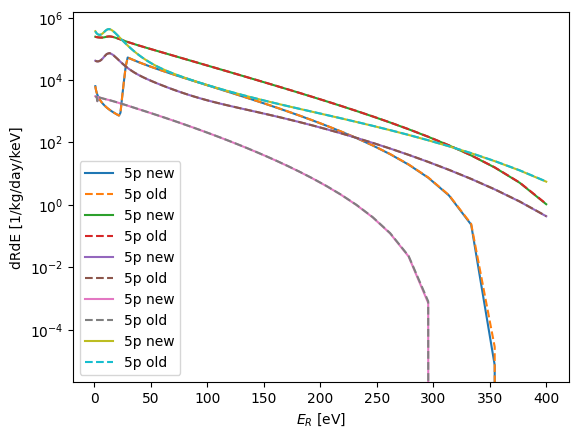

In [12]:
import matplotlib.pyplot as plt
import numericalunits as nu
for shell in dmrates.form_factor.keys:
    if shell in skip_keys[material]:
        continue
    plt.plot(erec,drs[shell].cpu(),label=f"{test_shell} new")
    plt.plot(erec,drs_old[shell]*years_per_day,label=f"{test_shell} old",ls='--')

plt.yscale('log')
plt.xlabel('$E_R$ [eV]')
plt.legend()
plt.ylabel("dRdE [1/kg/day/keV]")
plt.show()
plt.close()


In [13]:
import torch
nes = torch.arange(1,17)
n_el, drsrates_old = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=True,useVerne=True,verbose=False,integrate=False)
n_el, drsn_old_sun = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=False,useVerne=True,verbose=False,integrate=False)
drsn_old_sun[1]

np.float64(2239994426.8801303)

In [14]:
rates_new_allsum = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=False)

rates_new_all,shells = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=True)
shells

cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0


['Summed', '4p', '4d', '5s', '4s', '5p']

In [15]:
rates_new_allsum * nu.tonne * nu.year

tensor([[2.2375e+09],
        [1.5914e+09],
        [7.3931e+08],
        [9.6596e+08],
        [1.4615e+09],
        [1.2006e+09],
        [7.9403e+08],
        [5.1268e+08],
        [3.5408e+08],
        [2.5208e+08],
        [1.6706e+08],
        [1.1082e+08],
        [7.5059e+07],
        [5.0371e+07],
        [3.4068e+07],
        [2.2786e+07]])

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Ansh\AppData\Local\Temp\ipykernel_37804\744520448.py:4: SyntaxWarning: invalid escape sequence '\c'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"
C:\Users\Ansh\AppData\Local\Temp\ipykernel_37804\744520448.py:4: SyntaxWarning: invalid escape sequence '\s'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"


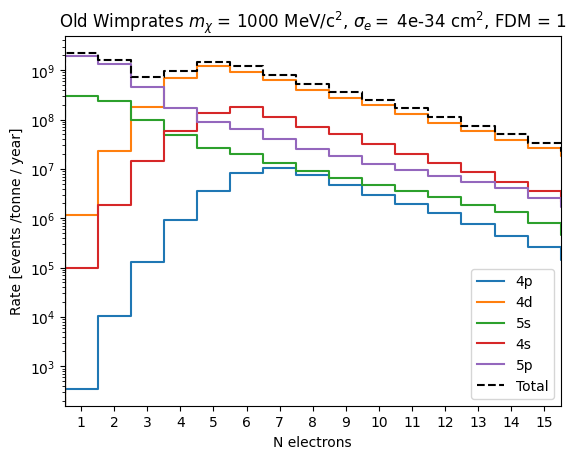

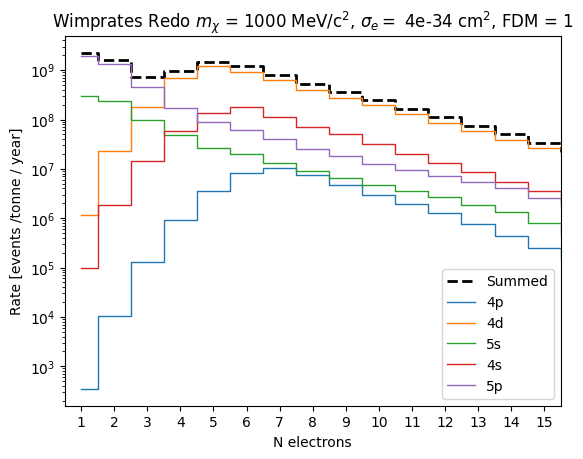

In [19]:
fdm_dict = {0: '1',
            2: '$1/q^2$'}
fdm_str = fdm_dict[FDMn]
title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}" 

plt.title('Old Wimprates '+title)# + (' -- SWAP 4s<->4p' if True else ''))
drsrates_old
for shell, rn in drsrates_old.items():
        plt.plot(n_el, np.array(rn), drawstyle='steps-mid', label=shell)
plt.plot(n_el, np.sum(np.array(list(drsrates_old.values())), axis=0),
            label='Total',
            drawstyle='steps-mid', 
            linestyle='--', 
            c='k')
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")
plt.show()
plt.close()

plt.title('Wimprates Redo ' + title)# + (' -- SWAP 4s<->4p' if True else ''))


for i,key in enumerate(shells):
        ls = '--' if i == 0 else None
        c = 'k' if i ==0 else None
        lw = 2 if i == 0 else 1
        r = rates_new_all[0][:,i] * nu.tonne * nu.year
        r = r.cpu()
        nes = nes.cpu()
        plt.plot(nes,r,drawstyle='steps-mid',label=key,ls=ls,c=c,lw=lw)
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")

plt.show()
plt.close()